# Investment Strategies — Buy & Hold (Long-Term Baseline)

**Goal:** Establish a clean baseline for long-term investing (buy & hold) using ETFs and selected stocks.
We will compute cumulative returns, CAGR, volatility, Sharpe, and max drawdown, and build rolling metrics.

**Data source:** SQLite DB built in the “Data Base & Ingestion” notebook.  
**Tools:** pandas, numpy, matplotlib, SQL (via pandas.read_sql_query).


## Step 1 — Imports & DB connection

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("bmh")

from pathlib import Path
DB_PATH =  Path(r"C:\Users\Ruben\Desktop\Projects\InvestmentStrategies\market.db")

# Helper to run SQL and return a DataFrame
def q(sql: str, params=None, parse_dates=None) -> pd.DataFrame:
    return pd.read_sql_query(sql, f"sqlite:///{DB_PATH}", params=params, parse_dates=parse_dates)


## Step 2 — Choose universe (benchmarks & peers)

In [2]:

BENCHMARKS = ["VTI", "SPY"]        # broad-market ETFs
ETFS       = ["VTI", "QQQ"]        # add a growth ETF for contrast
STOCKS     = ["AAPL", "MSFT"]      # pick a couple of mega-caps
TICKERS    = list(dict.fromkeys(BENCHMARKS + ETFS + STOCKS))  # deduplicate, keep order

START = "2018-01-01"   # you can set to "2020-01-01" if you prefer
END   = "2025-01-01"


## Step 3 — Pull price data from SQLite (wide format by symbol)

In [3]:

sql = """
SELECT date, symbol, close
FROM prices
WHERE symbol IN ({tickers})
  AND date BETWEEN :start AND :end
ORDER BY date, symbol
""".format(tickers=",".join([f":s{i}" for i,_ in enumerate(TICKERS)]))

params = {f"s{i}": s for i, s in enumerate(TICKERS)}
params.update({"start": START, "end": END})

df = q(sql, params=params, parse_dates=["date"])
wide = df.pivot(index="date", columns="symbol", values="close").sort_index()
wide = wide.dropna(how="all").ffill()   # forward fill small gaps if any

print(wide.head())
print(wide.tail())


symbol           AAPL       MSFT         QQQ         SPY         VTI
date                                                                
2018-01-02  40.380993  79.198318  150.605377  237.909134  122.186470
2018-01-03  40.373955  79.566917  152.068726  239.414017  122.893692
2018-01-04  40.561501  80.267204  152.334793  240.423111  123.362198
2018-01-05  41.023300  81.262375  153.864716  242.025192  124.087044
2018-01-08  40.870937  81.345306  154.463348  242.467850  124.369949
symbol            AAPL        MSFT         QQQ         SPY         VTI
date                                                                  
2024-12-24  257.286652  436.929108  527.965210  596.076965  294.369537
2024-12-26  258.103729  435.715790  527.606506  596.116699  294.537994
2024-12-27  254.685867  428.177216  520.593018  589.841614  291.347809
2024-12-30  251.307861  422.508331  513.669189  583.110596  288.127930
2024-12-31  249.534180  419.196564  509.305664  580.989136  287.127228


## Step 4 — Returns & cumulative returns

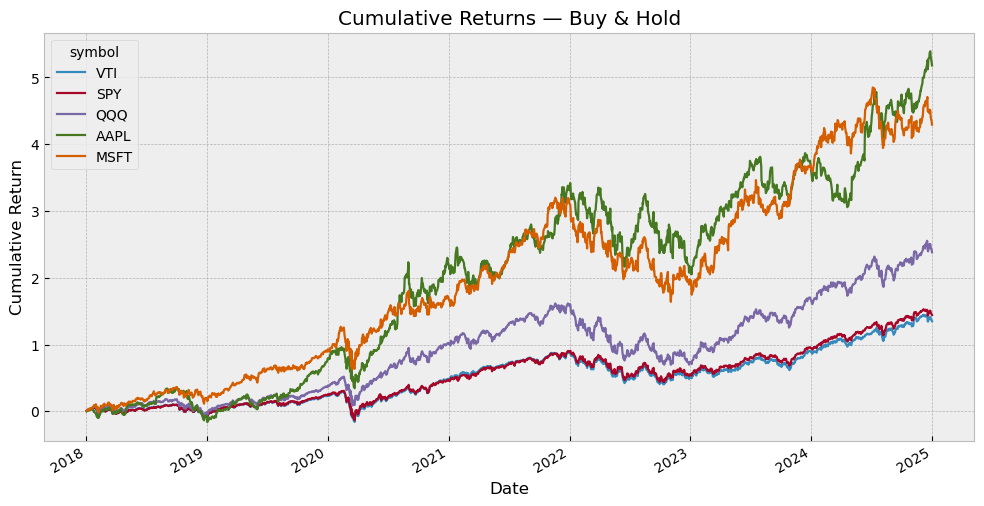

In [14]:

rets = wide.pct_change().dropna()

# Cumulative return from start: (1+r).cumprod() - 1
cum = (1 + rets).cumprod() - 1

ax = cum[TICKERS].plot(figsize=(12,6), lw=1.6, title="Cumulative Returns — Buy & Hold")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Return")
plt.show()


## Step 5 — Performance metrics (CAGR, Vol, Sharpe, Max Drawdown)

In [5]:

TRADING_DAYS = 252

def cagr(series: pd.Series) -> float:
    """Compound Annual Growth Rate from daily price series."""
    series = series.dropna()
    if len(series) < 2:
        return np.nan
    start, end = series.iloc[0], series.iloc[-1]
    years = (series.index[-1] - series.index[0]).days / 365.25
    return (end / start) ** (1/years) - 1 if years > 0 else np.nan

def ann_vol(daily_returns: pd.Series) -> float:
    """Annualized volatility from daily returns."""
    return daily_returns.std() * np.sqrt(TRADING_DAYS)

def sharpe(daily_returns: pd.Series, rf: float = 0.0) -> float:
    """Approx. Sharpe assuming constant risk-free rf (annual)."""
    mu = daily_returns.mean() * TRADING_DAYS
    sigma = ann_vol(daily_returns)
    return np.nan if sigma == 0 else (mu - rf) / sigma

def max_drawdown(price: pd.Series) -> float:
    """Max drawdown on price series (return as negative number)."""
    running_max = price.cummax()
    dd = price / running_max - 1.0
    return dd.min()

# Compute metrics per symbol
rows = []
for s in TICKERS:
    px = wide[s].dropna()
    rows.append({
        "Symbol": s,
        "CAGR": cagr(px),
        "Volatility": ann_vol(rets[s]),
        "Sharpe(≈)": sharpe(rets[s], rf=0.0),
        "MaxDrawdown": max_drawdown(px)
    })
summary = pd.DataFrame(rows).set_index("Symbol").sort_values("CAGR", ascending=False)
summary


,CAGR,Volatility,Sharpe(≈),MaxDrawdown
Symbol,,,,
AAPL,0.297390,0.305464,1.006812,-0.385159
MSFT,0.268986,0.288865,0.970821,-0.371485
QQQ,0.190263,0.241215,0.844468,-0.351187
SPY,0.136140,0.194610,0.754800,-0.337173
VTI,0.129909,0.199024,0.714776,-0.350003


## Step 6 — Rolling metrics: 1Y rolling return & 60-day volatility

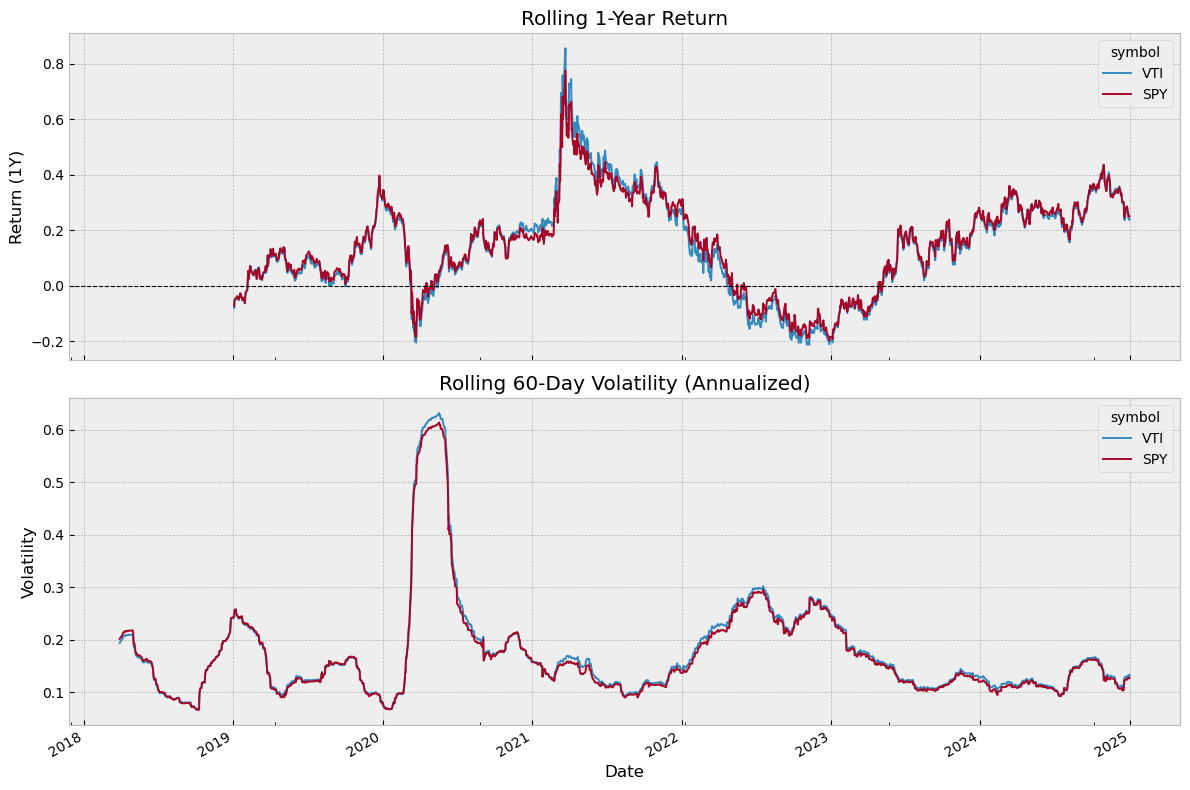

In [6]:

roll_1y = (1 + rets).rolling(TRADING_DAYS).apply(np.prod, raw=True) - 1
vol_60  = rets.rolling(60).std() * np.sqrt(TRADING_DAYS)

fig, axes = plt.subplots(2, 1, figsize=(12,8), sharex=True)
roll_1y[BENCHMARKS].plot(ax=axes[0], lw=1.4, title="Rolling 1-Year Return")
axes[0].axhline(0, color="k", ls="--", lw=0.8); axes[0].set_ylabel("Return (1Y)")
vol_60[BENCHMARKS].plot(ax=axes[1], lw=1.4, title="Rolling 60-Day Volatility (Annualized)")
axes[1].set_ylabel("Volatility"); axes[1].set_xlabel("Date")
plt.tight_layout(); plt.show()


## Step 7 — Compare VTI vs SPY vs AAPL/MSFT (buy & hold)

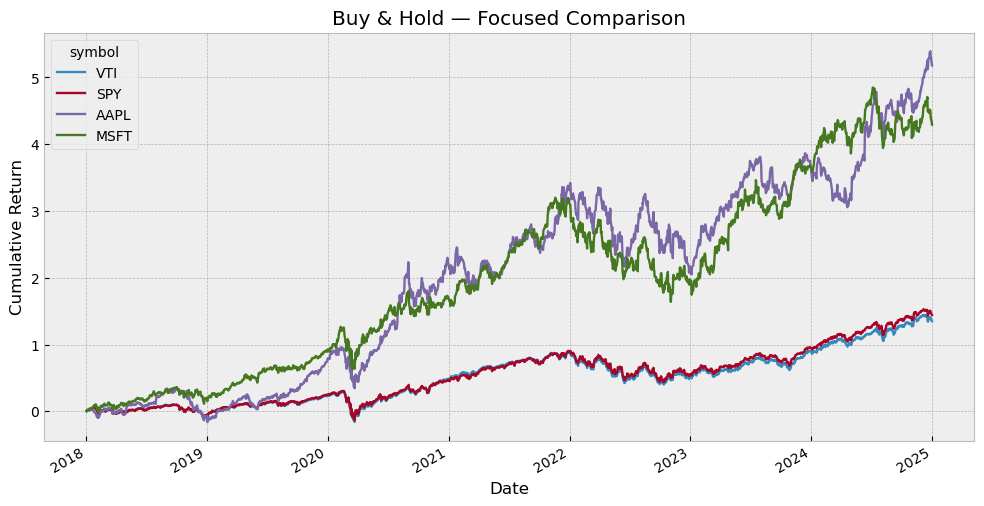

,CAGR,Volatility,Sharpe(≈),MaxDrawdown
Symbol,,,,
VTI,0.129909,0.199024,0.714776,-0.350003
SPY,0.136140,0.194610,0.754800,-0.337173
AAPL,0.297390,0.305464,1.006812,-0.385159
MSFT,0.268986,0.288865,0.970821,-0.371485


In [12]:

focus = ["VTI", "SPY", "AAPL", "MSFT"]
focus = [s for s in focus if s in cum.columns]

ax = cum[focus].plot(figsize=(12,6), lw=1.7, title="Buy & Hold — Focused Comparison")
ax.set_xlabel("Date"); ax.set_ylabel("Cumulative Return")
plt.show()

summary.loc[focus]


## Step 8 — Portfolio: equal-weight among chosen assets

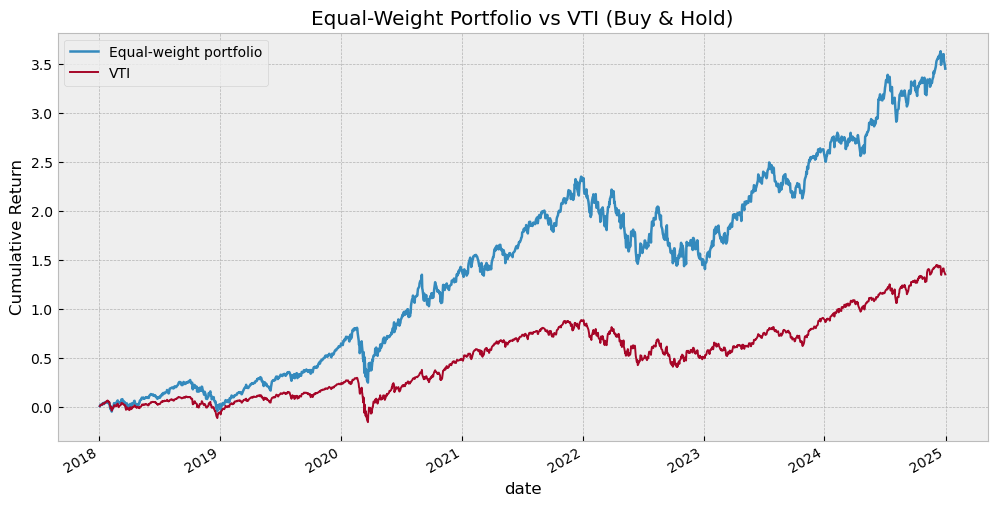

,Portfolio_CAGR,Portfolio_Sharpe(≈),Portfolio_MaxDD
0,0.217149,1.001953,-0.309979


In [8]:

basket = ["AAPL", "MSFT", "VTI"]
basket = [s for s in basket if s in rets.columns]

w = np.repeat(1/len(basket), len(basket))
port = rets[basket].dot(w)
cum_port = (1 + port).cumprod() - 1

ax = cum_port.plot(figsize=(12,6), lw=1.8, label="Equal-weight portfolio")
cum["VTI"].plot(ax=ax, lw=1.4, label="VTI")
plt.title("Equal-Weight Portfolio vs VTI (Buy & Hold)")
plt.ylabel("Cumulative Return"); plt.legend(); plt.show()

pd.DataFrame({
    "Portfolio_CAGR": [cagr(wide[basket].dot(w))],  # CAGR on price-like index
    "Portfolio_Sharpe(≈)": [sharpe(port)],
    "Portfolio_MaxDD": [max_drawdown((1+port).cumprod())]
})


## Step 9 — Takeaways

## Takeaways (Buy & Hold Baseline)

- **VTI (Total US Market)** serves as the primary long-term benchmark.
- Over the selected period, mega-caps (e.g., AAPL/MSFT) may outperform VTI, but with **higher volatility and deeper drawdowns**.
- **Equal-weight portfolio** of (AAPL, MSFT, VTI) provides a balanced compromise — potentially higher return than VTI alone, with diversified risk.
- Rolling 1Y returns and 60D volatility highlight **regimes** (calm vs. turbulent markets), useful for later strategies (Momentum, Mean Reversion).
- This notebook establishes a **clean baseline** to compare rule-based strategies later.
